# Imports

In [5]:
import pandas as pd
import numpy as np
import os
import datetime
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import pearsonr, spearmanr

from nltk.sentiment import SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, f1_score, accuracy_score,classification_report, recall_score, precision_score
# ROC curve
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.inspection import permutation_importance
import xgboost as xgb

# Data

In [6]:
gme=pd.read_csv('/home/pelle/Master_Thesis/data/raw/wallstreetbets/old/gamestop.csv')
gme['date'] = pd.to_datetime(gme['Date'])

In [7]:
df_post = pd.read_csv('/home/pelle/Master_Thesis/data/raw/wallstreetbets/submissions_pmaw_2016-2021_wsb.csv')
df_post['created_utc'] = pd.to_datetime(df_post['created_utc'])
df_post = df_post[df_post['author'] != '[deleted]']

In [10]:
df = df_post

df.title = df.title.str.lower() 
df.text = df.selftext.str.lower() 
df['GME_title'] = df.title.str.contains(' gme ' or ' $gme ' or ' gamestop ') 
df['GME_text'] = df.selftext.str.contains(' gme ' or ' $gme ' or '   ') 
df['GME'] = df.GME_title | df.GME_text

df['date_no_time'] = df['created_utc'].dt.date
gr=df.groupby(['date_no_time']).GME.sum()

/tmp/ipykernel_3436/3871710118.py:4: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df.text = df.selftext.str.lower()


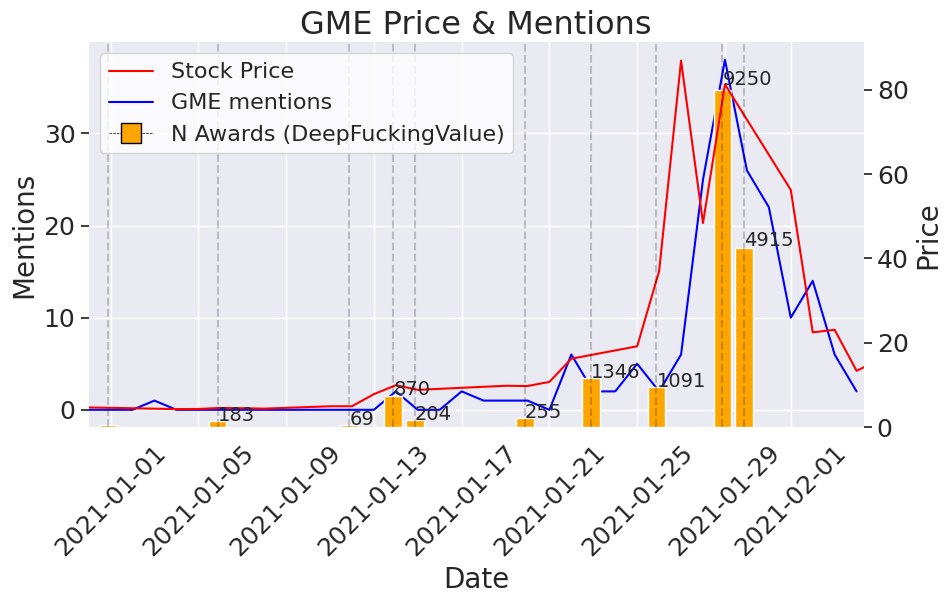

In [65]:
dfv=(df_post[df_post['author'] == 'DeepFuckingValue'].loc[df_post['created_utc']>datetime.datetime(2021, 1, 1, 0, 0)])

# twin y-axis 
sns.set_theme(style="darkgrid")
fig, ax1 = plt.subplots(figsize=(10,5))
sns.set_theme(style="white")
ax2 = ax1.twinx()

ax1.plot(gr.index,gr.values,color='blue')
ax2.plot(gme['date'],gme['Close'],color='red')
ax1.set_xlabel('Date',fontsize=20)
ax1.set_ylabel('Mentions',fontsize=20)
ax2.set_ylabel('Price',fontsize=20)

ax1.tick_params(axis='x', labelsize=18, rotation=45)
ax1.tick_params(axis='y', labelsize=18)
ax2.tick_params(axis='y', labelsize=18)

# ax1.set_yscale('log')
# ax2.set_yscale('log')

plt.bar(df_post[df_post['author'] == 'DeepFuckingValue']['created_utc'],df_post[df_post['author'] == 'DeepFuckingValue']['award_count']/(9250)*80,color='orange')
# text for each post from DeepFuckingValue
for i in range(len(dfv)):
    plt.text(dfv.iloc[i]['created_utc'],dfv.iloc[i]['award_count']/(9250)*81,int(dfv.iloc[i]['award_count']),fontsize=14)

plt.title('GME Price & Mentions',fontsize=23)
custom_scatter = [plt.Line2D([0], [0], color='red', markersize=8),
                    plt.Line2D([0], [0], color='blue', markersize=8),
                     plt.Line2D([0], [0], color='black',markerfacecolor='orange', label='N awards', markersize=15,marker='s',linewidth=0.5,linestyle='--')]
plt.legend(custom_scatter, ['Stock Price', 'GME mentions','N Awards (DeepFuckingValue)'],fontsize=16)

for i in range(len(df_post[df_post['author'] == 'DeepFuckingValue'])):
    plt.axvline(df_post[df_post['author'] == 'DeepFuckingValue'].iloc[i]['created_utc'], color='black', linestyle='--', alpha=0.2)

plt.xlim(datetime.datetime(2020, 12, 31, 0, 0), df_post['created_utc'].max())
sns.despine(left=True, bottom=True)
plt.show()
sns.set_theme(style="darkgrid")

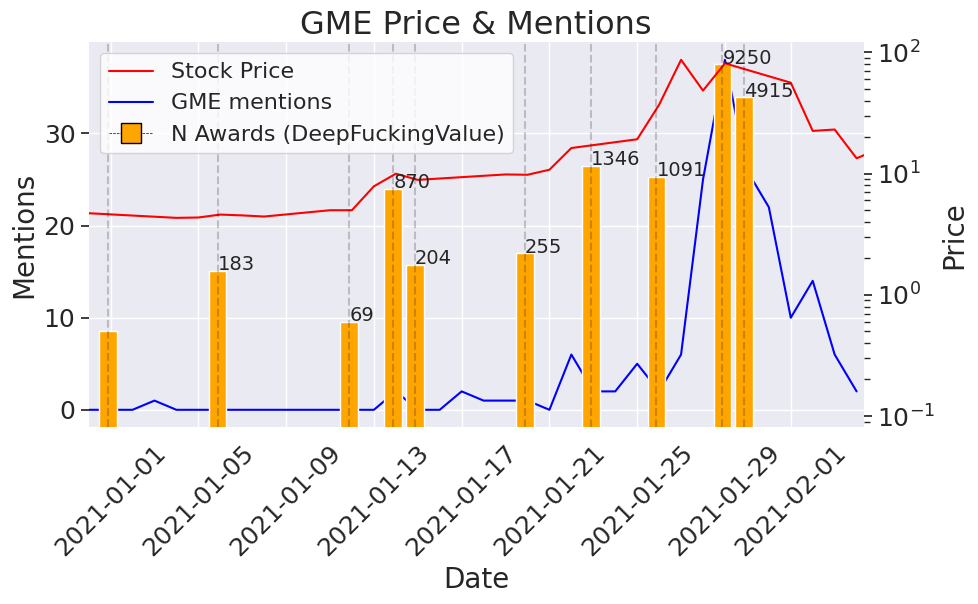

In [62]:
dfv=(df_post[df_post['author'] == 'DeepFuckingValue'].loc[df_post['created_utc']>datetime.datetime(2021, 1, 1, 0, 0)])

# twin y-axis 
sns.set_theme(style="darkgrid")
fig, ax1 = plt.subplots(figsize=(10,5))
sns.set_theme(style="white")
ax2 = ax1.twinx()

ax1.plot(gr.index,gr.values,color='blue')
ax2.plot(gme['date'],gme['Close'],color='red')
ax1.set_xlabel('Date',fontsize=20)
ax1.set_ylabel('Mentions',fontsize=20)
ax2.set_ylabel('Price',fontsize=20)

ax1.tick_params(axis='x', labelsize=18, rotation=45)
ax1.tick_params(axis='y', labelsize=18)
ax2.tick_params(axis='y', labelsize=18)

ax2.set_yscale('log')

plt.bar(df_post[df_post['author'] == 'DeepFuckingValue']['created_utc'],df_post[df_post['author'] == 'DeepFuckingValue']['award_count']/(9250)*80,color='orange')
# text for each post from DeepFuckingValue
for i in range(len(dfv)):
    plt.text(dfv.iloc[i]['created_utc'],dfv.iloc[i]['award_count']/(9250)*81,int(dfv.iloc[i]['award_count']),fontsize=14)

plt.title('GME Price & Mentions',fontsize=23)
custom_scatter = [plt.Line2D([0], [0], color='red', markersize=8),
                    plt.Line2D([0], [0], color='blue', markersize=8),
                     plt.Line2D([0], [0], color='black',markerfacecolor='orange', label='N awards', markersize=15,marker='s',linewidth=0.5,linestyle='--')]
plt.legend(custom_scatter, ['Stock Price', 'GME mentions','N Awards (DeepFuckingValue)'],fontsize=16)

for i in range(len(df_post[df_post['author'] == 'DeepFuckingValue'])):
    plt.axvline(df_post[df_post['author'] == 'DeepFuckingValue'].iloc[i]['created_utc'], color='black', linestyle='--', alpha=0.2)

plt.xlim(datetime.datetime(2020, 12, 31, 0, 0), df_post['created_utc'].max())
sns.despine(left=True, bottom=True)
plt.show()
sns.set_theme(style="darkgrid")

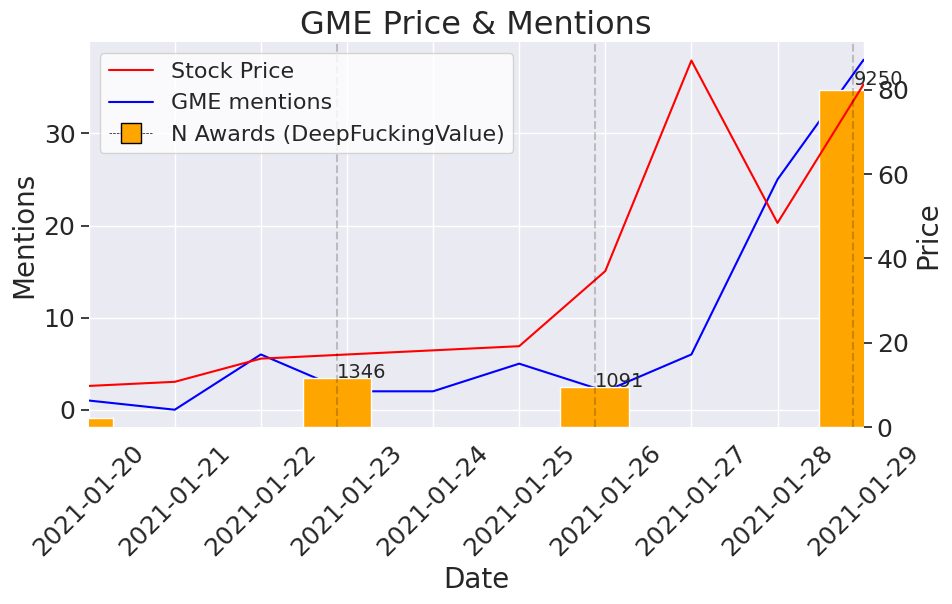

In [53]:
d_max = datetime.datetime(2021, 1, 29, 0, 0)
d_min = datetime.datetime(2021, 1, 20, 0, 0)

dfv=(df_post[df_post['author'] == 'DeepFuckingValue'].loc[df_post['created_utc']>d_min])
dfv=dfv.loc[dfv['created_utc']<d_max]

# twin y-axis 
sns.set_theme(style="darkgrid")
fig, ax1 = plt.subplots(figsize=(10,5))
sns.set_theme(style="white")
ax2 = ax1.twinx()

ax1.plot(gr.index,gr.values,color='blue')
ax2.plot(gme['date'],gme['Close'],color='red')
ax1.set_xlabel('Date',fontsize=20)
ax1.set_ylabel('Mentions',fontsize=20)
ax2.set_ylabel('Price',fontsize=20)

ax1.tick_params(axis='x', labelsize=18, rotation=45)
ax1.tick_params(axis='y', labelsize=18)
ax2.tick_params(axis='y', labelsize=18)

plt.bar(df_post[df_post['author'] == 'DeepFuckingValue']['created_utc'],df_post[df_post['author'] == 'DeepFuckingValue']['award_count']/(9250)*80,color='orange')
# text for each post from DeepFuckingValue
for i in range(len(dfv)):
    plt.text(dfv.iloc[i]['created_utc'],dfv.iloc[i]['award_count']/(9250)*81,int(dfv.iloc[i]['award_count']),fontsize=14)

plt.title('GME Price & Mentions',fontsize=23)
custom_scatter = [plt.Line2D([0], [0], color='red', markersize=8),
                    plt.Line2D([0], [0], color='blue', markersize=8),
                     plt.Line2D([0], [0], color='black',markerfacecolor='orange', label='N awards', markersize=15,marker='s',linewidth=0.5,linestyle='--')]
plt.legend(custom_scatter, ['Stock Price', 'GME mentions','N Awards (DeepFuckingValue)'],fontsize=16)

for i in range(len(df_post[df_post['author'] == 'DeepFuckingValue'])):
    plt.axvline(df_post[df_post['author'] == 'DeepFuckingValue'].iloc[i]['created_utc'], color='black', linestyle='--', alpha=0.2)

plt.xlim(d_min, d_max)
sns.despine(left=True, bottom=True)
plt.show()
sns.set_theme(style="darkgrid")

In [51]:

print(gme[gme['date']==datetime.datetime(2021, 1, 25, 0, 0)].Close)

print(gme[gme['date']==datetime.datetime(2021, 1, 27, 0, 0)].Close)


(gme[gme['date']==datetime.datetime(2021, 1, 27, 0, 0)].Close.values-gme[gme['date']==datetime.datetime(2021, 1, 25, 0, 0)].Close.values)/gme[gme['date']==datetime.datetime(2021, 1, 25, 0, 0)].Close.values*100

770    19.1975
Name: Close, dtype: float64
772    86.877502
Name: Close, dtype: float64


array([352.54591174])

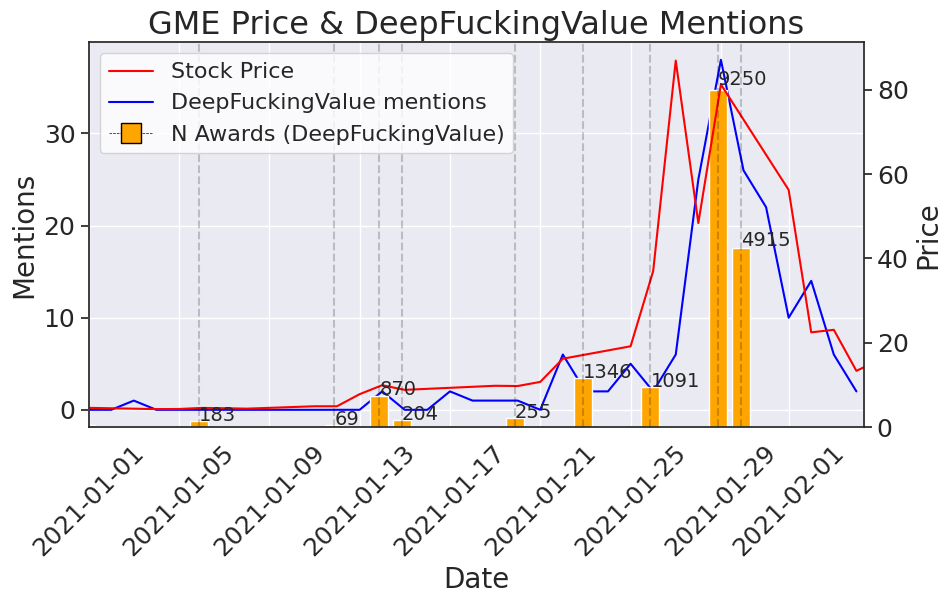

In [17]:
df = df_post
df.title = df.title.str.lower() 
df.text = df.selftext.str.lower() 
df['DFV_title'] = df.title.str.contains(' deepfuckingvalue ') 
df['DFV_text'] = df.selftext.str.contains(' deepfuckingvalue ') 
df['DFV'] = df.DFV_title | df.DFV_text
df['date_no_time'] = df['created_utc'].dt.date
gr=df.groupby(['date_no_time']).DFV.sum()

dfv=(df_post[df_post['author'] == 'DeepFuckingValue'].loc[df_post['created_utc']>datetime.datetime(2021, 1, 1, 0, 0)])

# twin y-axis 
sns.set_theme(style="darkgrid")
fig, ax1 = plt.subplots(figsize=(10,5))
sns.set_theme(style="white")
ax2 = ax1.twinx()

ax1.plot(gr.index,gr.values,color='blue')
ax2.plot(gme['date'],gme['Close'],color='red')
ax1.set_xlabel('Date',fontsize=20)
ax1.set_ylabel('Mentions',fontsize=20)
ax2.set_ylabel('Price',fontsize=20)

ax1.tick_params(axis='x', labelsize=18, rotation=45)
ax1.tick_params(axis='y', labelsize=18)
ax2.tick_params(axis='y', labelsize=18)

plt.bar(df_post[df_post['author'] == 'DeepFuckingValue']['created_utc'],df_post[df_post['author'] == 'DeepFuckingValue']['award_count']/(9250)*80,color='orange')
# text for each post from DeepFuckingValue
for i in range(len(dfv)):
    plt.text(dfv.iloc[i]['created_utc'],dfv.iloc[i]['award_count']/(9250)*81,int(dfv.iloc[i]['award_count']),fontsize=14)

plt.title('GME Price & DeepFuckingValue Mentions',fontsize=23)
custom_scatter = [plt.Line2D([0], [0], color='red', markersize=8),
                    plt.Line2D([0], [0], color='blue', markersize=8),
                     plt.Line2D([0], [0], color='black',markerfacecolor='orange', label='N awards', markersize=15,marker='s',linewidth=0.5,linestyle='--')]
plt.legend(custom_scatter, ['Stock Price', 'DeepFuckingValue mentions','N Awards (DeepFuckingValue)'],fontsize=16)

for i in range(len(df_post[df_post['author'] == 'DeepFuckingValue'])):
    plt.axvline(df_post[df_post['author'] == 'DeepFuckingValue'].iloc[i]['created_utc'], color='black', linestyle='--', alpha=0.2)

plt.xlim(datetime.datetime(2021, 1, 1, 0, 0), df_post['created_utc'].max())
plt.show()
sns.set_theme(style="darkgrid")

In [ ]:
df_post[df_post['author'] == 'DeepFuckingValue']

,id,author,created_utc,title,selftext,score,subreddit_subscribers,num_comments,award_count,GME_title,GME_text,GME,date_no_time
15685,gb3ctb,DeepFuckingValue,2020-04-30 20:16:00,gme yolo month-end update — apr 2020,NaN,1.0,-21202.0,42.0,18.0,False,NaN,False,2020-04-30
33407,g1e5at,DeepFuckingValue,2020-04-14 21:20:00,gme yolo update following the start of the big...,&amp;#x200B;\n\nhttps://preview.redd.it/p1vjv3...,-76.0,-10540.0,77.0,17.0,False,False,False,2020-04-14
59515,kny2rx,DeepFuckingValue,2020-12-31 21:05:04,gme yolo year-end update — dec 31 2020,NaN,1.0,-12815.0,108.0,58.0,False,NaN,False,2020-12-31
61477,kr7s30,DeepFuckingValue,2021-01-05 21:05:04,gme yolo update — jan 5 2021,NaN,1.0,3310.0,5.0,183.0,False,NaN,False,2021-01-05
75493,kvc22x,DeepFuckingValue,2021-01-11 21:02:56,gme yolo update — jan 11 2021,NaN,84.0,-30252.0,-52.0,69.0,False,NaN,False,2021-01-11
77245,kxeq23,DeepFuckingValue,2021-01-14 21:02:56,gme yolo update — jan 14 2021,NaN,8.0,1778.0,-78.0,204.0,False,NaN,False,2021-01-14
92736,kwpviw,DeepFuckingValue,2021-01-13 21:05:04,gme yolo update — jan 13 2021,NaN,46.0,-15838.0,-74.0,870.0,False,NaN,False,2021-01-13
112348,l0t8ng,DeepFuckingValue,2021-01-19 21:05:04,gme yolo update — jan 19 2021,NaN,69.0,472.0,80.0,255.0,False,NaN,False,2021-01-19
113276,l2x7he,DeepFuckingValue,2021-01-22 21:13:36,gme yolo update — jan 22 2021,NaN,2.0,-6172.0,114.0,1346.0,False,NaN,False,2021-01-22
141788,l4xje1,DeepFuckingValue,2021-01-25 21:05:04,gme yolo update — jan 25 2021,NaN,2.0,21187.0,52.0,1091.0,False,NaN,False,2021-01-25
